## Question 1.

# Sports Prediction

Sports Prediction

In sports prediction, large numbers of factors including the historical performance of the teams, results of matches, and data on players, have to be accounted for to help different stakeholders understand the odds of winning or losing.

## Data Preparation and Feature Extraction


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Import statements
import pandas as pd
import numpy as np
import random as rnd

# Encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Imputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Models
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [5]:
# loading the datasets with low_memory param set to false
# Pandas will attempt to load the entire dataset into memory at once
players_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/players_21.csv", low_memory=False)

# We'll clean up the '21 dataframe simultaneously
test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/players_22.csv", low_memory=False)

# show dataframe head
players_df.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,103500000.0,560000.0,33,...,52+3,52+3,52+3,62+3,19+3,https://cdn.sofifa.net/players/158/023/21_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",92,92,63000000.0,220000.0,35,...,54+3,54+3,54+3,61+3,20+3,https://cdn.sofifa.net/players/020/801/21_120.png,https://cdn.sofifa.net/teams/45/60.png,https://cdn.sofifa.net/flags/it.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png
2,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,91,91,111000000.0,240000.0,31,...,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/21_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,NaN,https://cdn.sofifa.net/flags/pl.png
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,132000000.0,270000.0,28,...,49+3,49+3,49+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/21_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,"CAM, CM",91,91,129000000.0,370000.0,29,...,69+3,69+3,69+3,75+3,21+3,https://cdn.sofifa.net/players/192/985/21_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png


In [6]:
# We don't need the player urls so we'll delete those
players_df = players_df[players_df.columns.drop(list(players_df.filter(regex='url')))]
test_df = test_df[test_df.columns.drop(list(test_df.filter(regex='url')))]

### Missing entries

Missing entries are problematic when it comes to training a prediction model. These missing values could skew the model to over or underfit on the training data thereby giving us inaccurate predictions.

In [8]:
# We need to worry about missing entries
# Suppose a column has at least half of its rows empty, we'll drop them

cols_with_more_than_half_entries_missing = []

for i in players_df.columns:
    missing_entries = np.abs((players_df[i].count() - players_df[i].shape[0])/players_df[i].shape[0] * 100)
    if missing_entries > 50:
        cols_with_more_than_half_entries_missing.append(i)

# Display the name of the columns with a lot of missing entries
print(cols_with_more_than_half_entries_missing)

['club_loaned_from', 'nation_team_id', 'nation_position', 'nation_jersey_number', 'player_tags', 'player_traits', 'goalkeeping_speed']


In [9]:
# From above, we can see the various columns that have a lot of missing entries
# We need to drop them from the dataset
players_df.drop(columns = cols_with_more_than_half_entries_missing, inplace=True)
test_df.drop(columns = cols_with_more_than_half_entries_missing, inplace=True)

players_df.head()

,sofifa_id,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,158023,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,103500000.0,560000.0,33,1987-06-24,...,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3,19+3
1,20801,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",92,92,63000000.0,220000.0,35,1985-02-05,...,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3,20+3
2,188545,R. Lewandowski,Robert Lewandowski,ST,91,91,111000000.0,240000.0,31,1988-08-21,...,65+3,65+3,65+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3
3,190871,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,132000000.0,270000.0,28,1992-02-05,...,62+3,62+3,62+3,67+3,62+3,49+3,49+3,49+3,62+3,20+3
4,192985,K. De Bruyne,Kevin De Bruyne,"CAM, CM",91,91,129000000.0,370000.0,29,1991-06-28,...,80+3,80+3,80+3,79+3,75+3,69+3,69+3,69+3,75+3,21+3


From the results above, we can see that we have 97 columns now instead of the initial 110 we started with. This process of elimination will help us narrow down our dataset and leave us with columns that will be relevant for training.

In [7]:
# The next code block will drop some columns based on prefixes
# We will need the 'skill_moves' column so we will rename it to 'skill'
players_df.rename(columns = {'skill_moves':'skill'}, inplace=True)
test_df.rename(columns = {'skill_moves':'skill'}, inplace=True)

In [10]:
# We want to still narrow our dataset down to mostly relevant columns
# We'll use the following filter to drop some more columns

# We will be dropping columns that have the following prefixes
# Overall player ratings are seldom dependent on these
regex_filter = ['sofifa_id','skill_','movement_','defending_','goalkeeping_','attacking_','power_','mentality_']

for i in regex_filter:
    players_df = players_df[players_df.columns.drop(list(players_df.filter(regex=i)))]
    test_df = test_df[test_df.columns.drop(list(test_df.filter(regex=i)))]
#Determining how may columns we have left
print(f"We now have {players_df.shape[1]} columns to work with\n")
print(players_df.columns)

We now have 62 columns to work with

Index(['short_name', 'long_name', 'player_positions', 'overall', 'potential',
       'value_eur', 'wage_eur', 'age', 'dob', 'height_cm', 'weight_kg',
       'club_team_id', 'club_name', 'league_name', 'league_level',
       'club_position', 'club_jersey_number', 'club_joined',
       'club_contract_valid_until', 'nationality_id', 'nationality_name',
       'preferred_foot', 'weak_foot', 'skill', 'international_reputation',
       'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic', 'ls', 'st',
       'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm',
       'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb', 'gk'],
      dtype='object')


In [11]:
# We notice from the results above that from 'ls' to 'rb' are player positions
# For shortness, we will take the columns from 'short_name' to 'physic'

roles = ['short_name','age','height_cm','weight_kg','nationality_name','club_name','overall','potential','league_name','league_level',
          'value_eur','wage_eur','player_positions','preferred_foot','international_reputation',
          'skill', 'work_rate', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

non_positions = players_df[roles]

tnpos = test_df[roles]

positions = non_positions['player_positions'].value_counts().head(20)

tpos = tnpos['player_positions'].value_counts().head(20)

# We will now check what rows are empty
# if the sum is anything other than '0', then there are missing rows in that column

non_positions.isnull().sum()

short_name                     0
age                            0
height_cm                      0
weight_kg                      0
nationality_name               0
club_name                    225
overall                        0
potential                      0
league_name                  225
league_level                 225
value_eur                    237
wage_eur                     225
player_positions               0
preferred_foot                 0
international_reputation       0
skill                          0
work_rate                      0
pace                        2083
shooting                    2083
passing                     2083
dribbling                   2083
defending                   2083
physic                      2083
dtype: int64

In [12]:
# Most player positions have rw, st, or cf in their name
# We can assume that all the above fall under rw
non_positions['player_positions'] = non_positions['player_positions'].apply(lambda x: x.split(',')[0].strip())
tnpos['player_positions'] = tnpos['player_positions'].apply(lambda x: x.split(',')[0].strip())

# We can now obtain a set (more like a list) of unique positions
unique_positions = non_positions['player_positions'].unique()
tdf_unique = tnpos['player_positions'].unique()

<ipython-input-12-db8d073664bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_positions['player_positions'] = non_positions['player_positions'].apply(lambda x: x.split(',')[0].strip())
<ipython-input-12-db8d073664bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tnpos['player_positions'] = tnpos['player_positions'].apply(lambda x: x.split(',')[0].strip())


In [13]:
# Next, instead of pestering our model with more nominal data
# We can simplify the training by using 'league_level' instead of
# league_name, club_name, nationality_name or short_name

non_positions = non_positions.drop(columns=['nationality_name', 'club_name', 'league_name', 'short_name'])
tnpos = tnpos.drop(columns=['nationality_name', 'club_name', 'league_name', 'short_name'])

# Question 2
### Data preprocessing

This section mostly deals with trying to convert/encode typical categorical data into integer forms that will be easier to train with.

For starters, the `preferred_foot` column can be encoded into binary data using a OneHotEncoder. Afterall, it has only two categorical values, i.e. right foot or left foot. We could encode it such that **right foot** is `0` and **left foot** is `1`.

In [14]:
bin_encoder = OneHotEncoder(sparse = False)

_encoded = bin_encoder.fit_transform(non_positions[['preferred_foot']])
tdf_encoded = bin_encoder.fit_transform(tnpos[['preferred_foot']])

encoded_data = pd.DataFrame(_encoded, columns = bin_encoder.categories_[0])
tdf_endata = pd.DataFrame(tdf_encoded, columns = bin_encoder.categories_[0])

data_encoded = pd.concat([non_positions, encoded_data], axis = 1)
tdf_datencoded = pd.concat([tnpos, tdf_endata], axis = 1)

data_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,height_cm,weight_kg,overall,potential,league_level,value_eur,wage_eur,player_positions,preferred_foot,...,skill,work_rate,pace,shooting,passing,dribbling,defending,physic,Left,Right
0,33,170,72,93,93,1.0,103500000.0,560000.0,RW,Left,...,4,Medium/Low,85.0,92.0,91.0,95.0,38.0,65.0,1.0,0.0
1,35,187,83,92,92,1.0,63000000.0,220000.0,ST,Right,...,5,High/Low,89.0,93.0,81.0,89.0,35.0,77.0,0.0,1.0
2,31,184,80,91,91,1.0,111000000.0,240000.0,ST,Right,...,4,High/Medium,78.0,91.0,78.0,85.0,43.0,82.0,0.0,1.0
3,28,175,68,91,91,1.0,132000000.0,270000.0,LW,Right,...,5,High/Medium,91.0,85.0,86.0,94.0,36.0,59.0,0.0,1.0
4,29,181,70,91,91,1.0,129000000.0,370000.0,CAM,Right,...,4,High/High,76.0,86.0,93.0,88.0,64.0,78.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18939,21,177,70,47,52,1.0,70000.0,1000.0,CB,Right,...,2,Low/Low,58.0,23.0,26.0,27.0,50.0,48.0,0.0,1.0
18940,21,174,68,47,53,1.0,70000.0,1000.0,CM,Right,...,2,Low/Low,58.0,32.0,49.0,47.0,43.0,48.0,0.0,1.0
18941,28,185,79,47,47,1.0,45000.0,2000.0,CM,Right,...,2,Low/Low,65.0,37.0,49.0,46.0,40.0,59.0,0.0,1.0
18942,17,171,58,47,67,4.0,130000.0,500.0,ST,Right,...,2,Medium/Medium,70.0,46.0,40.0,53.0,16.0,40.0,0.0,1.0


We can use `LabelEncoder` to encode all the categorical columns in the `data_encoded` dataframe as integers. This allows for easier processing by algorithms.

In [15]:
label_encoder = LabelEncoder()

for i in data_encoded.select_dtypes(['object']):
    data_encoded[i] = label_encoder.fit_transform(data_encoded[i])

for j in tdf_datencoded.select_dtypes(['object']):
    tdf_datencoded[j] = label_encoder.fit_transform(tdf_datencoded[j])


data_encoded.info()

# What we expect to see are most of the columns data type
# switching from 'Object' to 'int64'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18944 entries, 0 to 18943
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       18944 non-null  int64  
 1   height_cm                 18944 non-null  int64  
 2   weight_kg                 18944 non-null  int64  
 3   overall                   18944 non-null  int64  
 4   potential                 18944 non-null  int64  
 5   league_level              18719 non-null  float64
 6   value_eur                 18707 non-null  float64
 7   wage_eur                  18719 non-null  float64
 8   player_positions          18944 non-null  int64  
 9   preferred_foot            18944 non-null  int64  
 10  international_reputation  18944 non-null  int64  
 11  skill                     18944 non-null  int64  
 12  work_rate                 18944 non-null  int64  
 13  pace                      16861 non-null  float64
 14  shooti

#### Missing Values

Above, we examined how many missing entries we had present in the dataset. We dropped some and saved some columns. The remaining columns however are crucial for the prediction model we're trying to develop, hence, we'll use `KNNImputer` to attempt to impute the missing values.

In [16]:
cols_w_missing_vals = data_encoded.columns[data_encoded.isnull().any()].tolist()
tdf_cwmv = tdf_datencoded.columns[tdf_datencoded.isnull().any()].tolist()

imputed = data_encoded.copy()
tdf_imp = tdf_datencoded.copy()

imput_data = imputed[cols_w_missing_vals].copy()
tdf_impdata = tdf_imp[tdf_cwmv].copy()

imputer = KNNImputer(n_neighbors = 6)

imputed_data = imputer.fit_transform(imput_data)
tdf_id = imputer.fit_transform(tdf_impdata)

imputed[cols_w_missing_vals] = imputed_data
tdf_imp[tdf_cwmv] = tdf_id

In [17]:
# Checking to see if there are any missing rows now
imputed.isnull().sum()

age                         0
height_cm                   0
weight_kg                   0
overall                     0
potential                   0
league_level                0
value_eur                   0
wage_eur                    0
player_positions            0
preferred_foot              0
international_reputation    0
skill                       0
work_rate                   0
pace                        0
shooting                    0
passing                     0
dribbling                   0
defending                   0
physic                      0
Left                        0
Right                       0
dtype: int64

In [18]:
# We will now convert the remaining float64 columns into neat int64 columns
f_cols = imputed.select_dtypes(include=['float']).columns
dtf_cols = tdf_imp.select_dtypes(include=['float']).columns

imputed[f_cols] = imputed[f_cols].astype(int)
tdf_imp[dtf_cols] = tdf_imp[dtf_cols].astype(int)

tdf_imp['player_positions'] = tdf_imp['player_positions'].astype(int)
#tdf_imp['preferred_foot'] = tdf_imp['preferred_foot'].astype(int)

tdf_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   age                       19239 non-null  int64
 1   height_cm                 19239 non-null  int64
 2   weight_kg                 19239 non-null  int64
 3   overall                   19239 non-null  int64
 4   potential                 19239 non-null  int64
 5   league_level              19239 non-null  int64
 6   value_eur                 19239 non-null  int64
 7   wage_eur                  19239 non-null  int64
 8   player_positions          19239 non-null  int64
 9   preferred_foot            19239 non-null  int64
 10  international_reputation  19239 non-null  int64
 11  skill                     19239 non-null  int64
 12  work_rate                 19239 non-null  int64
 13  pace                      19239 non-null  int64
 14  shooting                  19239 non-nu

#Question 3 & Question 4
## Prediction

We're done tidying up the dataset. We've eliminated as many uncertain variables that might result in an inaccurate model. We're now confronted with the challenge of picking a model to work with.

The best contenders for the job are models that can toe the line between regression and classification. In our case, our goal is to 'predict' a new set of values based on old ones, this is a heavily-regression-based problem.

Our options are thus `LinearRegression`, `RandomForrest` and `K-Nearest Neighbors`. For the sake of simplicity, we'll only consider LinearRegression and RandomForrest and compare their performances.

#### Training with Linear Regression

For this, we need to select the optimal subset of features for a linear regression model. We can do this using the Recursive Feature Elimination with Cross-Validation (RFECV) algorithm.

In [20]:
# We'll drop 'overall' since its the target feature and 'potential'
# We're dropping potential simply because its way too closely related to overall
X = imputed.drop(columns=['overall', 'potential'])
tdf_X = tdf_imp.drop(columns=['overall', 'potential'])

y = imputed['overall']
tdf_y = tdf_imp['overall']

lr_model = LinearRegression()
rfecv = RFECV(estimator=lr_model, scoring='neg_mean_squared_error')

X_selected = rfecv.fit_transform(X, y)
selected_features = X.columns[rfecv.support_]

print(f"Number of optimal features: {rfecv.n_features_}\n{selected_features}")

Number of optimal features: 16
Index(['age', 'height_cm', 'weight_kg', 'league_level', 'preferred_foot',
       'international_reputation', 'skill', 'work_rate', 'pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'Left', 'Right'],
      dtype='object')


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We'll create the regression model using a pipeline that includes
# a StandardScaler object for feature scaling and
# a LinearRegression object for modelling

pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('linearregression', LinearRegression())
])

pipeline.fit(X_train, y_train)

y_pred_test = pipeline.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'Mean Squared Error(MSE) test:{mse_test:.4f}')
print(f'Root Mean Squared Error (RMSE) test:{rmse_test:.4f}')
print(f'R-squared test:{r2_test:.4f}\n{"="*40}')
y_pred = pipeline.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print(f'Mean Squared Error(MSE) all:{mse:.4f}')
print(f'Root Mean Squared Error (RMSE) all:{rmse:.4f}')
print(f'R-squared all:{r2:.4f}')

print(f"\nCoeff Of Determination (Accuracy): {(pipeline.score(X_test, y_test) * 100):.4f}%")

Mean Squared Error(MSE) test:9.6776
Root Mean Squared Error (RMSE) test:3.1109
R-squared test:0.7947
Mean Squared Error(MSE) all:9.2798
Root Mean Squared Error (RMSE) all:3.0463
R-squared all:0.8107

Coeff Of Determination (Accuracy): 79.4684%


#### Training with RandomForrest

In [29]:
# Over here, we'll create another regression model using the
# RandomForestRegressor object

rf = RandomForestRegressor(random_state=42)


rf.fit(X_train, y_train)


y_pred_test_rfg = rf.predict(X_test)

mse_test_rf = mean_squared_error(y_test, y_pred_test_rfg)
rmse_test_rf = np.sqrt(mse_test_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rfg)

y_pred_neigh_acc = neigh.predict(X)
y_pred_rfg = rf.predict(X)
mse_all_rf = mean_squared_error(y, y_pred_rfg)
rmse_all_rf = np.sqrt(mse_all_rf)
r2_all_rf = r2_score(y, y_pred_rfg)

print(f'Mean Squared Error(MSE) test:{mse_test_rf:.4f}')
print(f'Root Mean Squared Error (RMSE) test:{rmse_test_rf:.4f}')
print(f'R-squared test:{r2_test_rf:.4f}\n{"="*40}')
print(f'Mean Squared Error(MSE) all:{mse_all_rf:.4f}')
print(f'Root Mean Squared Error (RMSE) all:{rmse_all_rf:.4f}')
print(f'R-squared all:{r2_all_rf:.4f}')

print(f"\nCoeff Of Determination (Accuracy): {(rf.score(X_test, y_test) * 100):.4f}%")

Mean Squared Error(MSE) test:0.5047
Root Mean Squared Error (RMSE) test:0.7104
R-squared test:0.9893
Mean Squared Error(MSE) all:0.1669
Root Mean Squared Error (RMSE) all:0.4085
R-squared all:0.9966

Coeff Of Determination (Accuracy): 98.9292%


#### Training with KNNRegressor

In [24]:
# Here we'll create a K-Nearest Neighbour Regressor

neigh = KNeighborsRegressor(n_neighbors=7)
neigh.fit(X_train, y_train)

y_pred_neigh = neigh.predict(X_test)

mse_test_neigh = mean_squared_error(y_test, y_pred_neigh)
rmse_test_neigh = np.sqrt(mse_test_neigh)
r2_test_neigh = r2_score(y_test, y_pred_neigh)


y_pred_neigh_acc = rf.predict(X)
mse_all_neigh = mean_squared_error(y, y_pred_neigh_acc)
rmse_all_neigh = np.sqrt(mse_all_neigh)
r2_all_neigh = r2_score(y, y_pred_neigh_acc)

print(f'Mean Squared Error(MSE) test:{mse_test_neigh:.4f}')
print(f'Root Mean Squared Error (RMSE) test:{rmse_test_neigh:.4f}')
print(f'R-squared test:{r2_test_neigh:.4f}\n{"="*40}')
print(f'Mean Squared Error(MSE) all:{mse_all_neigh:.4f}')
print(f'Root Mean Squared Error (RMSE) all:{rmse_all_neigh:.4f}')
print(f'R-squared all:{r2_all_neigh:.4f}')

print(f"\nCoeff Of Determination (Accuracy): {(neigh.score(X_test, y_test) * 100):.4f}%")

Mean Squared Error(MSE) test:6.0583
Root Mean Squared Error (RMSE) test:2.4614
R-squared test:0.8715
Mean Squared Error(MSE) all:0.1669
Root Mean Squared Error (RMSE) all:0.4085
R-squared all:0.9966

Coeff Of Determination (Accuracy): 87.1469%


## Comparing the models

We now have functioning models that could be used to predict the overall ratings of a football player based on certain 16 features. We'd like to now see which model was more effective for the purposes we required.

We can do this by comparing their various metrics in an algorithm and dataset analysis application like `WEKA` or we could plot the predicted versus real values of each model and see which delivers the best results.

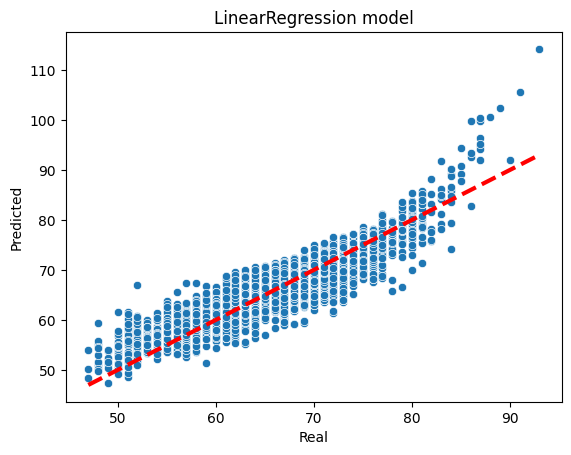

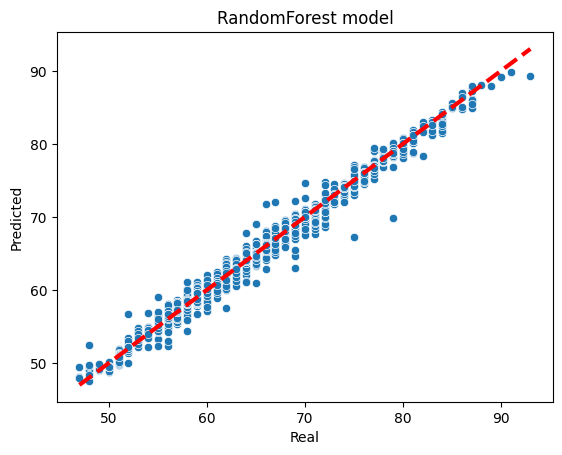

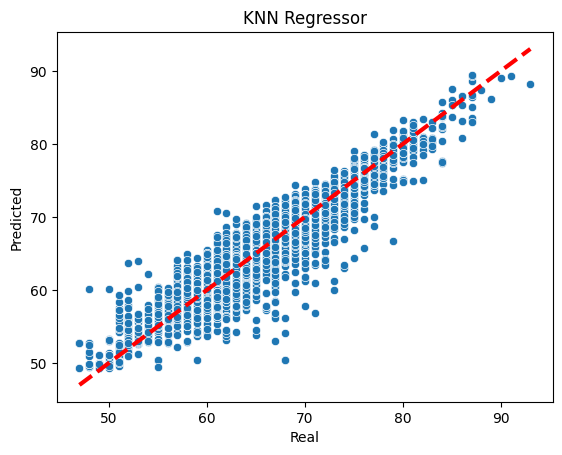

In [25]:
data1 = pd.DataFrame({'Real': y_test, 'Predicted': y_pred_test})

sns.scatterplot(data=data1, x='Real', y='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title("LinearRegression model")
plt.show()

data2 = pd.DataFrame({'Real': y_test, 'Predicted': y_pred_test_rfg})

sns.scatterplot(data=data2, x='Real', y='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title("RandomForest model")
plt.show()

data3 = pd.DataFrame({'Real': y_test, 'Predicted': y_pred_neigh})

sns.scatterplot(data=data3, x='Real', y='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title("KNN Regressor")
plt.show()

Going by the scatter plots above, we observe that the randomforest model fares better than the linear regression model since the points stay close to the line of regression. Thus we can conclude the the model for the job is `RandomForest` as per our analysis.

#Question 5
### Testing the RF Model on the 2022 Dataset

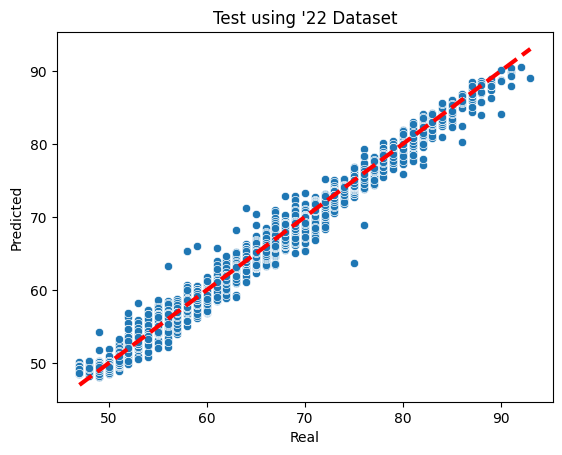

Mean Squared Error: 0.4339
Coefficient of Determination: 99.0833%


In [26]:
from sklearn.metrics import accuracy_score

tdf_pred = rf.predict(tdf_X)

data3 = pd.DataFrame({'Real': tdf_y, 'Predicted': tdf_pred})

sns.scatterplot(data=data3, x='Real', y='Predicted')
plt.plot([tdf_y.min(), tdf_y.max()], [tdf_y.min(), tdf_y.max()], 'r--', lw=3)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title("Test using '22 Dataset")
plt.show()

print(f"Mean Squared Error: {mean_squared_error(tdf_y, tdf_pred):.4f}")
print(f"Coefficient of Determination: {(rf.score(tdf_X, tdf_y) * 100):.4f}%")

### Saving the model using Pickle

In [27]:
import pickle
import bz2

# saving as random_forest_regression_model
pkl_file = "model.pkl"
oFile = bz2.BZ2File(pkl_file, 'wb')
pickle.dump(rf, oFile)
oFile.close()